# 6EXO


In [ ]:
import numpy as np
import pandas as pd
import ray
from scipy import interpolate
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.io as pio
from src.simulation import simulation_jump_exo, simulation_jump_pulse_exo
import os
pio.templates.default = "none"
pyo.init_notebook_mode()

In [2]:
γ3_list = np.linspace(0,1/3,20)
θ_list = pd.read_csv("data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
df  = pd.read_csv("data/iamc_db.csv",
                       header=None).to_numpy()
df2_temp = pd.read_csv("data/Extended_RCP_Emissions.csv",
                       header=None).T.to_numpy()
γ1 = 0.00017675
γ2 = 2*0.0022

In [3]:
ray.shutdown()
ray.init(log_to_driver=False)

File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'
2021-08-25 17:23:00,296	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.4',
 'raylet_ip_address': '192.168.1.4',
 'redis_address': '192.168.1.4:6379',
 'object_store_address': '/tmp/ray/session_2021-08-25_17-22-57_767134_4146/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-25_17-22-57_767134_4146/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-08-25_17-22-57_767134_4146',
 'metrics_export_port': 64647,
 'node_id': '5585a48f8f955f222032f8e5af3258d59b4a78d513e68a80ed605051'}

In [4]:
iteration_list = {}
iteration = np.linspace(0, 10, 11, dtype=int)
models    = np.linspace(0,8,9, dtype=int)
iteration_list=[simulation_jump_exo.remote(df,γ1, γ2, γ3_list, θ_list[j], iteration[k], models[m], 1.1, 79, 1)
                for k in range(len(iteration))
                for j in range(len(θ_list))
                for m in range(len(models))]
iteration_list = ray.get(iteration_list)




In [5]:
iteration_list_pulse = {}
iteration = np.linspace(0, 10, 11, dtype=int)
models    = np.linspace(0,8,9, dtype=int)
iteration_list_pulse=[simulation_jump_pulse_exo.remote(df,γ1, γ2, γ3_list, θ_list[j], iteration[k], models[m], 1.1, 79, 1)
                for k in range(len(iteration))
                for j in range(len(θ_list))
                for m in range(len(models))]
iteration_list_pulse = ray.get(iteration_list_pulse)

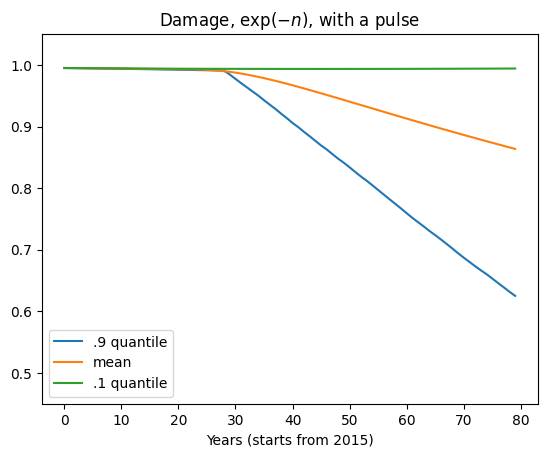

In [8]:
list_len = len(θ_list)* len(iteration)* len(models)
Damages_list = np.zeros((list_len, 80))
for i in range(list_len):
    Damages_list[i] = iteration_list[i]['Damages']
n_9 = np.quantile(Damages_list, 0.9, axis=0)
n_5 = np.mean(Damages_list, axis=0)
n_1 = np.quantile(Damages_list, 0.1, axis=0)
plt.figure()
plt.plot(np.exp(-n_9), label=".9 quantile")
plt.plot(np.exp(-n_5), label="mean")
plt.plot(np.exp(-n_1), label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Damage, $\exp (-n)$, with a pulse")
plt.ylim(0.45, 1.05)
plt.show()

<Figure size 640x480 with 0 Axes>

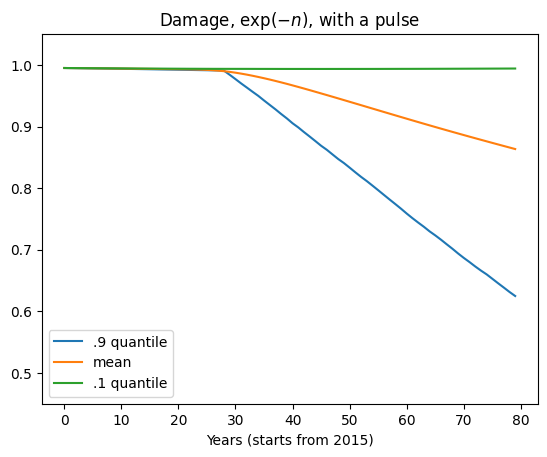

In [11]:
list_len = len(θ_list)* len(iteration)* len(models)
Damages_list_pulse = np.zeros((list_len, 80))
for i in range(list_len):
    Damages_list_pulse[i] = iteration_list_pulse[i]['Damages']
n_9_p = np.quantile(Damages_list_pulse, 0.9, axis=0)
n_5_p = np.mean(Damages_list_pulse, axis=0)
n_1_p = np.quantile(Damages_list_pulse, 0.1, axis=0)
plt.figure()
plt.plot(np.exp(-n_9_p), label=".9 quantile")
plt.plot(np.exp(-n_5_p), label="mean")
plt.plot(np.exp(-n_1_p), label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Damage, $\exp (-n)$, with a pulse")
plt.ylim(0.45, 1.05)
plt.show()

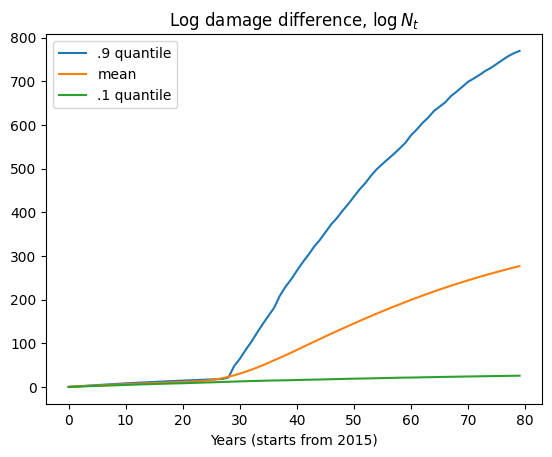

In [12]:

t = np.arange(0, len(n_9[0:80]))
plt.figure()
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_9 + n_9_p) ) * 1000* 85, label=".9 quantile")
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_5 + n_5_p) ) * 1000* 85, label="mean")
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_1 + n_1_p) )* 1000* 85, label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Log damage difference, $\log N_t$")
plt.show()

In [4]:
iteration_list = {}
iteration = np.linspace(0, 10, 11, dtype=int)
models    = np.linspace(0,3,4, dtype=int)
df2 = df2_temp[:,255:]
iteration_list=[simulation_jump_exo.remote(df2,γ1, γ2, γ3_list, θ_list[j], iteration[k], models[m], 1.1, 480, 1)
                for k in range(len(iteration))
                for j in range(len(θ_list))
                for m in range(len(models))]
iteration_list = ray.get(iteration_list)




In [12]:
iteration_list_pulse = {}
iteration = np.linspace(0, 10, 11, dtype=int)
models    = np.linspace(0,3,4, dtype=int)
iteration_list_pulse=[simulation_jump_pulse_exo.remote(df2,γ1, γ2, γ3_list, θ_list[j], iteration[k], models[m], 1.1, 480, 1)
                for k in range(len(iteration))
                for j in range(len(θ_list))
                for m in range(len(models))]
iteration_list_pulse = ray.get(iteration_list_pulse)

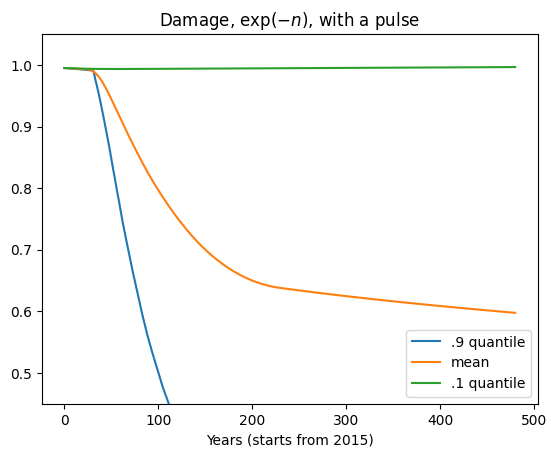

In [9]:
list_len = len(θ_list)* len(iteration)* len(models)
Damages_list = np.zeros((list_len, 481))
for i in range(list_len):
    Damages_list[i] = iteration_list[i]['Damages']
n_9 = np.quantile(Damages_list, 0.9, axis=0)
n_5 = np.mean(Damages_list, axis=0)
n_1 = np.quantile(Damages_list, 0.1, axis=0)
plt.figure()
plt.plot(np.exp(-n_9), label=".9 quantile")
plt.plot(np.exp(-n_5), label="mean")
plt.plot(np.exp(-n_1), label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Damage, $\exp (-n)$, with a pulse")
plt.ylim(0.45, 1.05)
plt.show()

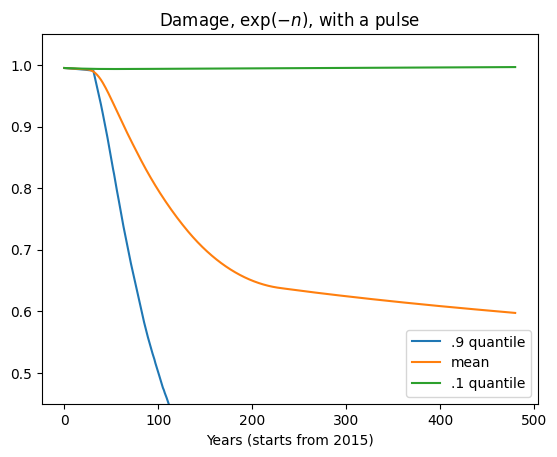

In [14]:
list_len = len(θ_list)* len(iteration)* len(models)
Damages_list_pulse = np.zeros((list_len, 481))
for i in range(list_len):
    Damages_list_pulse[i] = iteration_list_pulse[i]['Damages']
n_9_p = np.quantile(Damages_list_pulse, 0.9, axis=0)
n_5_p = np.mean(Damages_list_pulse, axis=0)
n_1_p = np.quantile(Damages_list_pulse, 0.1, axis=0)
plt.figure()
plt.plot(np.exp(-n_9_p), label=".9 quantile")
plt.plot(np.exp(-n_5_p), label="mean")
plt.plot(np.exp(-n_1_p), label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Damage, $\exp (-n)$, with a pulse")
plt.ylim(0.45, 1.05)
plt.show()

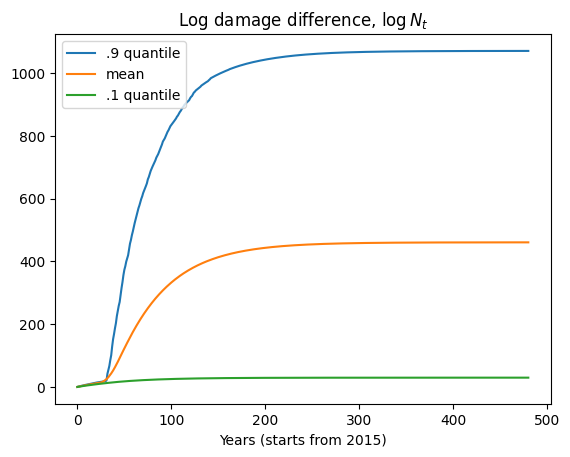

In [15]:
t = np.arange(0, len(n_9))
plt.figure()
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_9 + n_9_p) ) * 1000* 85, label=".9 quantile")
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_5 + n_5_p) ) * 1000* 85, label="mean")
plt.plot(np.cumsum(np.exp( - 0.02 *t) *(-n_1 + n_1_p) )* 1000* 85, label=".1 quantile")
plt.legend()
plt.xlabel("Years (starts from 2015)")
plt.title(r"Log damage difference, $\log N_t$")
plt.show()